In [17]:
import numpy as np
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.client import device_lib
print([dev.name for dev in device_lib.list_local_devices()])

['/device:CPU:0', '/device:GPU:0']


2024-01-23 17:31:08.777520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:31:08.777763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:31:08.777854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:31:08.778166: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:31:08.778192: I tensorflow/core/common_runtime/gpu/gpu

# Encode / Decode

In [18]:
def decode(tensor):
    """
    Converts the 12 uint64s into a 768 float32 tensor.
    """
    masks = tf.convert_to_tensor(2 ** np.arange(64, dtype=np.int64))
    masked = tf.bitwise.bitwise_and(tf.expand_dims(tensor, -1), masks)
    expanded = tf.cast(tf.not_equal(masked, 0), dtype=tf.float32)
    return tf.reshape(expanded, (-1, 768))

# Expected empty board ecoding
# [71776119061217280, 4755801206503243776, 2594073385365405696, 9295429630892703744, 576460752303423488, 1152921504606846976, 65280, 66, 36, 129, 8, 16]
def encode(board):
    """
    Encode into a 12 uint64 tensor.
    """
    bytes = [0] * 8 * 12

    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            match piece.symbol():
                case "P": channel = 0
                case "N": channel = 1
                case "B": channel = 2
                case "R": channel = 3
                case "Q": channel = 4
                case "K": channel = 5
                case "p": channel = 6
                case "n": channel = 7
                case "b": channel = 8
                case "r": channel = 9
                case "q": channel = 10
                case "k": channel = 11

            rank = i // 8
            file = i % 8

            bytes[7 - rank + channel * 8] |= 1 << file

    return np.array(bytes, dtype=np.uint8).view(np.uint64)

# Load dataset

In [19]:
# read file
dataset = tf.data.Dataset.list_files('../data/dataset/*.bin')
dataset = tf.data.FixedLengthRecordDataset(dataset, record_bytes=3 * 12 * 8)
dataset = dataset.map(lambda s: tf.reshape(tf.io.decode_raw(s, tf.int64), (3, 12)))
dataset = dataset.batch(4096)

In [20]:
batch = next(iter(dataset.take(1)))
batch.shape

TensorShape([4096, 3, 12])

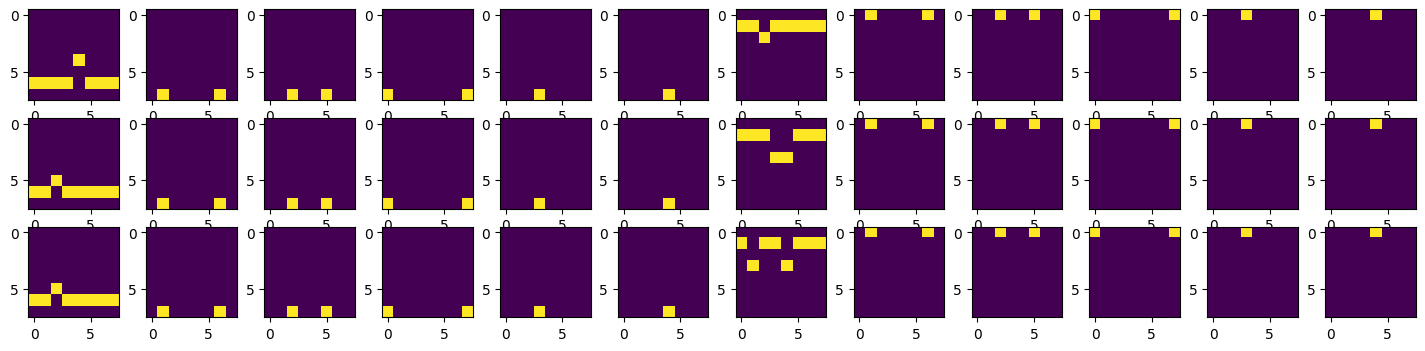

In [21]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 12, figsize=(18, 4))
for kind in range(3):
    for layer in range(12):
        axs[kind][layer].imshow(decode(batch.numpy()[0]).numpy()[kind].reshape((12,8,8))[layer])
plt.show()

# Train

In [22]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Concatenate, Lambda
from keras.optimizers import SGD

In [23]:
def custom_loss(_y_true, y_pred):
    """
    Compute loss as defined in https://erikbern.com/2014/11/29/deep-learning-for-chess.html
    // sum(p,q,r)logS(f(q)−f(r))+K*log(f(p)+f(q))+K*log(−f(q)−f(p))
    """
    p = y_pred[0]
    q = y_pred[1]
    r = y_pred[2]
    K = 10.0

    a = - tf.math.log(tf.math.sigmoid(q - r))
    b = 0 # - K * tf.math.log(tf.math.sigmoid(p + q))
    c = 0 # - K * tf.math.log(tf.math.sigmoid(-q - p))

    return a + b + c

def make_chess_model():
    inp = tf.keras.Input(shape=(12,), dtype=tf.int64)
    x = decode(inp) # convert 12 ints to 768 floats
    x = Dense(2048, activation="relu")(x)
    x = Dense(2048, activation="relu")(x)
    x = Dense(2048, activation="relu")(x)
    x = Dense(1)(x)
    return Model(inp, x)

def make_siamese_model(chess_model):
    boards = tf.keras.Input(shape=(3, 12), dtype=tf.int64)

    p_board = boards[:, 0, :]
    q_board = boards[:, 1, :]
    r_board = boards[:, 2, :]

    p = chess_model(p_board)
    q = chess_model(q_board)
    r = chess_model(r_board)

    model = Model(
        inputs=[boards],
        outputs=[p, q, r]
    )
    model.compile('adam', loss=custom_loss, metrics=[])
    return model

chess_model = make_chess_model()
train_model = make_siamese_model(chess_model)
chess_model.summary()
train_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 tf.expand_dims_1 (TFOpLamb  (None, 12, 1)             0         
 da)                                                             
                                                                 
 tf.bitwise.bitwise_and_1 (  (None, 12, 64)            0         
 TFOpLambda)                                                     
                                                                 
 tf.math.not_equal_1 (TFOpL  (None, 12, 64)            0         
 ambda)                                                          
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 12, 64)            0         
                                                           

In [24]:
chess_model(batch[0])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[ 0.04675839],
       [-0.02570879],
       [ 0.0342226 ]], dtype=float32)>

In [25]:
train_model.predict(batch)

128/128 [==============================] - 1s 4ms/step


[array([[ 0.04675845],
        [ 0.05067917],
        [-0.00712879],
        ...,
        [-0.04926181],
        [ 0.03122512],
        [-0.00721111]], dtype=float32),
 array([[-0.02570879],
        [ 0.0021032 ],
        [ 0.0998733 ],
        ...,
        [ 0.01356414],
        [ 0.01350659],
        [ 0.05014119]], dtype=float32),
 array([[ 0.03422263],
        [ 0.01322076],
        [ 0.07624642],
        ...,
        [-0.00219598],
        [-0.00492179],
        [ 0.06508601]], dtype=float32)]

In [26]:
history = train_model.fit(
    dataset.map(lambda x : (x, tf.constant([0.0]))),
    epochs=5
)

Epoch 1/5


     33/Unknown - 6s 140ms/step - loss: 3.0284 - model_2_loss: 1.0215 - model_2_1_loss: 1.0043 - model_2_2_loss: 1.0026

In [ ]:
history.history["loss"]

[2.2545623779296875,
 2.068470001220703,
 1.9689358472824097,
 1.5896105766296387,
 1.9549715518951416]

In [ ]:
import chess

board1 = chess.Board()
board1.push_san("e4")
board2 = chess.Board()
board2.push_san("a3")

chess_model(encode(board1)), chess_model(encode(board2))

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.30887306]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1152108]], dtype=float32)>)

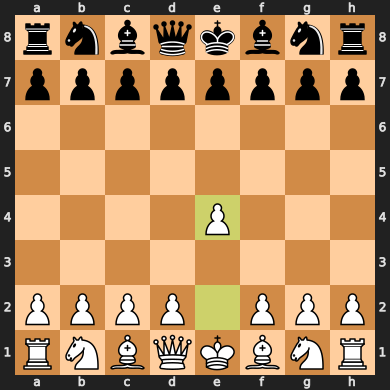

In [ ]:
board1

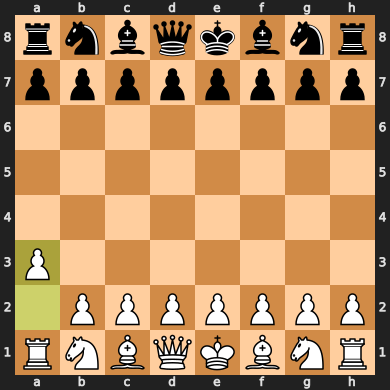

In [ ]:
board2

In [ ]:
chess_model.save("chess_model.h5")

/home/mlomb/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
